<a href="https://colab.research.google.com/github/richpar3/data_science_repo/blob/master/Citi_Bikes_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Citi Bike NYC - Capstone Project**

We start by importing the necessary packages and authenticating in BigQuery

In [0]:
#import packages
from google.cloud import bigquery #https://github.com/googleapis/google-cloud-python/tree/master/bigquery
from google.colab import auth
from google.colab import files 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime as dt
import seaborn as sns



pd.options.display.max_rows = 50
pd.options.display.max_columns = 4

In [0]:
#BigQuery Authentication
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='citi-bike-ds-project')

In [3]:
#extracting yearly trip counts from entire data set in order to properly sample the data
query = 'SELECT extract(YEAR from starttime) AS years, COUNT(*) AS tripcount FROM `bigquery-public-data.new_york_citibike.citibike_trips` GROUP BY extract(YEAR from starttime)'
query_job = client.query(query)  # API request
rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df = df[df['years']>0]
# df = df.set_index('years')
df = df.sort_values(by='years')
df = df.reset_index(drop=True)

total_sum = df['tripcount'].sum()
df['weight'] = df['tripcount'].apply(lambda x: x/total_sum)
print(df)


    years  tripcount    weight
0  2013.0    5037185  0.094847
1  2014.0    8081216  0.152164
2  2015.0    9937969  0.187125
3  2016.0   10262649  0.193238
4  2017.0   14118669  0.265845
5  2018.0    5671033  0.106782


---
1. Pull in all of our necessary data sources:


*   Citi Bike trips
*   Citi Bike stations
*   Weather for 2013 to present

---



In [0]:
%%time


query_list = []

#Extracting every year's data with two queries, except for 2013 and 2018 since they have limited data already
query1_2013 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2013-07-01\' and starttime <= \'2013-12-31\' ORDER BY rand() LIMIT '+ str(int(df.loc[0, 'weight'] * 1000000))
query1_2014 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2014-01-01\' and starttime <= \'2014-06-30\' ORDER BY rand() LIMIT '+ str(int(df.loc[1, 'weight'] * 1000000)) 
query2_2014 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2014-07-01\' and starttime <= \'2014-12-31\' ORDER BY rand() LIMIT '+ str(int(df.loc[1, 'weight'] * 1000000))
query1_2015 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2015-01-01\' and starttime <= \'2015-06-30\' ORDER BY rand() LIMIT '+ str(int(df.loc[2, 'weight'] * 1000000))
query2_2015 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2015-07-01\' and starttime <= \'2015-12-31\' ORDER BY rand() LIMIT '+ str(int(df.loc[2, 'weight'] * 1000000))
query1_2016 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2016-01-01\' and starttime <= \'2016-06-30\' ORDER BY rand() LIMIT '+ str(int(df.loc[3, 'weight'] * 1000000))
query2_2016 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2016-07-01\' and starttime <= \'2016-12-31\' ORDER BY rand() LIMIT '+ str(int(df.loc[3, 'weight'] * 1000000))
query1_2017 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2017-01-01\' and starttime <= \'2017-06-30\' ORDER BY rand() LIMIT '+ str(int(df.loc[4, 'weight'] * 1000000))
query2_2017 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2017-07-01\' and starttime <= \'2017-12-31\' ORDER BY rand() LIMIT '+ str(int(df.loc[4, 'weight'] * 1000000))
query1_2018 = 'SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime is not null and starttime >= \'2018-01-01\' and starttime <= \'2018-06-30\' ORDER BY rand() LIMIT '+ str(int(df.loc[5, 'weight'] * 1000000))

query_list.append(query1_2013)
query_list.append(query1_2014)
query_list.append(query2_2014)
query_list.append(query1_2015)
query_list.append(query2_2015)
query_list.append(query1_2016)
query_list.append(query2_2016)
query_list.append(query1_2017)
query_list.append(query2_2017)
query_list.append(query1_2018)

counter = 0
dataframe = {}

for query in query_list:
  query_job = client.query(query)  # API request
  rows = query_job.result()  # Waits for query to finish
  dataframe[counter] = query_job.to_dataframe()
  print("Query ", counter, " complete")
  counter += 1
  
df_trip = pd.concat(dataframe.values(), ignore_index=True)

Query  0  complete
Query  1  complete
Query  2  complete
Query  3  complete
Query  4  complete
Query  5  complete
Query  6  complete
Query  7  complete


In [0]:
#check null values
def null_check(df):
  df1 = df.isnull().sum().sum()
  
  if df1 == 0:
    print("There are no null values in the dataframe")
  else:
    print("There are ",df1,"null values:")
    print("---------------------------------")
    print(df.isnull().sum())

null_check(df_trip)

#filling in missing years with median birth year
df_trip['birth_year'] = df_trip['birth_year'].fillna(df_trip['birth_year'].median())

In [0]:
#Remove duplicates

def duplicates_check(df):
  df = df[df.duplicated()]

  if df.empty:
    print("There are no duplicates in the dataframe")
  else:
    print(df)

duplicates_check(df_trip)

In [0]:
#Adding new columns to Citi Bike Trips table

#Adding new columns from data
df_trip['date'] = df_trip['starttime'].dt.date
df_trip['month'] = df_trip['starttime'].dt.month
df_trip['year'] = df_trip['starttime'].dt.year
df_trip['tripduration_minutes'] = df_trip['tripduration']/60

#Age added
df_trip['age'] = dt.datetime.now().year - df_trip['birth_year']

#Time of day added
bins = [0, 5, 13, 17, 21, 25]
labels = ['Late Night','Morning','Afternoon','Evening', 'Night']
hours = df_trip['starttime'].dt.hour
df_trip['time_of_day'] = pd.cut(hours,bins=bins,labels=labels,right=False)

#Setting index
df_trip = df_trip.set_index(df_trip['starttime'])
df_trip = df_trip.sort_index()

#Day of Week
df_trip['date'] = pd.to_datetime(df_trip['date'])

# df_trip['day_of_week'] = df_trip['date'].apply(lambda x: x.strftime("%A"))
df_trip['day_of_week'] = df_trip['date'].dt.day_name()

In [0]:
%%time

#Citi Bike Stations
QUERY = ('SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_stations` ')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
df_stat = query_job.to_dataframe()

#Setting index
df_stat = df_stat.set_index(df_stat['station_id'])
df_stat = df_stat.sort_index()

CPU times: user 86 ms, sys: 2.99 ms, total: 89 ms
Wall time: 4.08 s


In [0]:
#remove null
null_check(df_stat)


There are no null values in the dataframe


In [0]:
#remove duplicates
duplicates_check(df_stat)

There are no duplicates in the dataframe


In [0]:
uploaded = files.upload()
df_weather = pd.read_csv('2013-2018_weather_data.csv')

weather_names = {
  'WT03':'Thunder', 
  'WESF':'Water equivalent of snowfall', 
  'WT04':'Ice pellets, sleet, snow pellets, or small hail', 
  'PRCP':'Precipitation',
  'WT05':'Hail (may include small hail)',
  'WT06':'Glaze or rime',
  'WT08':'Smoke or haze',
  'MDSF':'Multiday snowfall total',
  'SNWD':'Snow depth',
  'WT09':'Blowing or drifting snow',
  'DASF':'Number of days included in the multiday snow fall total (MDSF)', 
  'WDF2':'Direction of fastest 2-minute wind',
  'WDF5':'Direction of fastest 5-second wind',
  'PGTM':'Peak gust time',
  'WT11':'High or damaging winds',
  'TMAX':'Maximum temperature',
  'DAPR':'Number of days included in the multiday precipitation total (MDPR)',
  'WSF2':'Fastest 2-minute wind speed',
  'WSF5':'Fastest 5-second wind speed',
  'SNOW':'Snowfall',
  'TOBS':'Temperature at the time of observation',
  'AWND':'Average wind speed',
  'WT01':'Fog, ice fog, or freezing fog (may include heavy fog)',
  'WESD':'Water equivalent of snow on the ground',
  'WT02':'Heavy fog or heaving freezing fog (not always distinguished from fog)',
  'TAVG':'Average Temperature.',
  'TMIN':'Minimum temperature',
  'MDPR':'Multiday precipitation total (use with DAPR and DWPR, if available)',
  'TSUN':'Total sunshine for the period'
}

In [0]:
# df_weather = df_weather.set_index('DATE')
lists = [df_weather['DATE'], df_weather['STATION']]
df_weather.set_index(['DATE', 'STATION'], inplace=True)
df_weather = df_weather.sort_index()


In [0]:
print(df_weather.head())

In [0]:
# print(df_weather.info())
df_w1 = df_weather
keeping = ['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'PRCP']
df_w1 = df_w1[keeping]
df_w1 = df_w1.dropna()
print(df_w1.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43159 entries, (2013-07-01, US1NJBG0002) to (2018-05-31, USW00094741)
Data columns (total 5 columns):
NAME         43159 non-null object
LATITUDE     43159 non-null float64
LONGITUDE    43159 non-null float64
ELEVATION    43159 non-null float64
PRCP         43159 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.8+ MB
None


In [0]:
#remove null
null_check(df_w1)

There are no null values in the dataframe


In [0]:
#remove duplicates
duplicates_check(df_w1)

---
2. Look for any missing values or outliers in the data sets

---



In [0]:
#Inspecting Trips
print("Latest trip: ", df_trip['starttime'].max())
print("First trip: ", df_trip['starttime'].min())
print(df_trip.columns)
print(df_trip.describe())
print(df_trip.head())
df_trip.info()


In [0]:
#Inspect station data
print(df_stat.columns)
print(df_stat.describe())
print(df_stat.head())
df_stat.info()


In [0]:
#Inspect station data
print(df_w1.columns)
print(df_w1.describe())
print(df_w1.head())
df_w1.info()

---
3. Now we will check our dependent variable (trip duration) has any outliers

---



Trip duration data


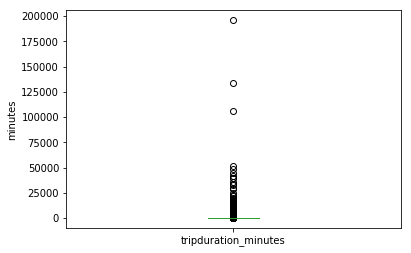

Trip duration excluding outliers


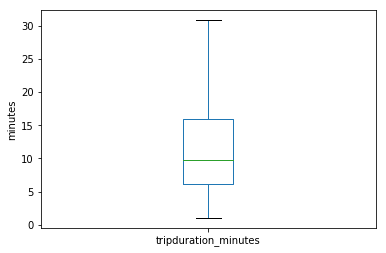

Histogram


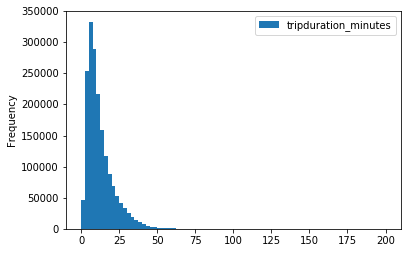

Cumulative Distribution


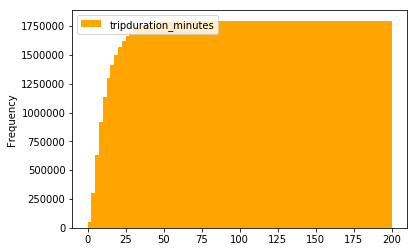

Standard Deviation:  230
Mean:  14
Removing trips with minutes greater than:  704
Number of trips >  704  minutes =  658 / 1798365 -->  0.03658879037347813
 


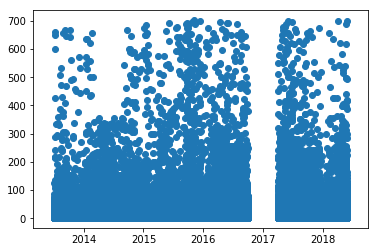

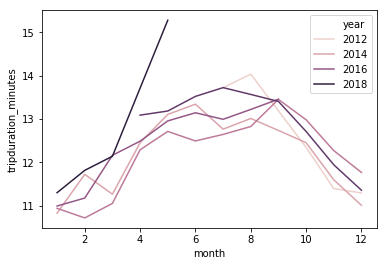

In [0]:
print("Trip duration data")
df_trip.plot(kind='box', y='tripduration_minutes')
plt.ylabel('minutes')
plt.show()

print("Trip duration excluding outliers")
df_trip.plot(kind='box', y='tripduration_minutes', showfliers=False)
plt.ylabel('minutes')
plt.show()

print("Histogram")
df_trip.plot(kind='hist', y='tripduration_minutes', bins=80, range=(0,200))
plt.show()

print("Cumulative Distribution")
df_trip.plot(kind='hist', y='tripduration_minutes', bins=80, range=(0,200), cumulative=True, color='orange')
plt.show()

#We will remove anything past 3 standard deviations from the mean
std = int(df_trip['tripduration_minutes'].std())
mean = int(df_trip['tripduration_minutes'].mean())
outlier = int(mean + (std*3))
print("Standard Deviation: ", std)
print("Mean: ", mean)
print("Removing trips with minutes greater than: ", outlier)
outliers_df = df_trip[df_trip['tripduration_minutes']>outlier]
print("Number of trips > ", outlier, " minutes = ", outliers_df.shape[0],"/", df_trip.shape[0], "--> ", (outliers_df.shape[0]/df_trip.shape[0])*100)
print(" ")

df_trip1 = df_trip[df_trip['tripduration_minutes']<outlier]
plt.scatter(df_trip1['date'],df_trip1['tripduration_minutes'])
plt.show()

df_avg = df_trip1.resample('M').mean()
df_avg['startdate'] = df_avg.index
df_avg['year'] = df_avg['startdate'].dt.year
df_avg['month'] = df_avg['startdate'].dt.month

sns.lineplot(data=df_avg, x="month", y="tripduration_minutes", hue="year")
            

Note: We removed any trip that is greater than 3 standard deviations because this likely represents a scenario where someone forgot to return the bike and doesn't accurately represent a true trip

Since this is only a sample from the full data set, let's pull more data explicitly from the data set for these dates and see if it is truly missing

In [0]:
%%time
QUERY = ('SELECT starttime, tripduration FROM `bigquery-public-data.new_york_citibike.citibike_trips` where starttime between \'2017-01-01\' and \'2017-03-31\' limit 1000000')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
df_blank_years = query_job.to_dataframe()

print(df_blank_years.head())


Empty DataFrame
Columns: [starttime, tripduration]
Index: []
CPU times: user 37.3 ms, sys: 2.99 ms, total: 40.2 ms
Wall time: 2.75 s


Conclusion: We get a blank dataframe, even when we query directly from the data source for anything from the first quarter in 2017. We can confirm that the data set does not exist for this period.

---
4.Next we want to check our possible independent variables (age, gender, usertype, time_of_day, day_of_week, start_station_name, end_station_name, weather, etc.) for outliers

---



In [0]:
print("   Age")
print(df_trip1[df_trip1['age']>100]['age'].describe())
print(df_trip1['age'].unique())
print(df_trip1['age'].value_counts())
df_trip1 = df_trip1[df_trip1['age']<100]
print("--------------------------------")

print("   Gender")
print(df_trip1['gender'].describe())
print(df_trip1['gender'].unique())
print(df_trip1['gender'].value_counts())
print("--------------------------------")

print("   Usertype")
print(df_trip1['usertype'].describe())
print(df_trip1['usertype'].unique())
print(df_trip1['usertype'].value_counts())

print("--------------------------------")

print("   Time of day")
print(df_trip1['time_of_day'].describe())
print(df_trip1['time_of_day'].unique())
print(df_trip1['time_of_day'].value_counts())

print("--------------------------------")

print("   day_of_week")
print(df_trip1['day_of_week'].describe())
print(df_trip1['day_of_week'].unique())
print(df_trip1['day_of_week'].value_counts())

print("--------------------------------")

print("   start_station_name")
print(df_trip1['start_station_name'].describe())
print(df_trip1['start_station_name'].value_counts())
print("--------------------------------")

print("   end_station_name")
print(df_trip1['end_station_name'].describe())
print(df_trip1['end_station_name'].value_counts())


   Age
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age, dtype: float64
[38 31 37 60 65 36 32 34 42 47 54 35 59 44 39 33 48 27 50 41 49 43 45 52
 53 46 40 58 29 62 30 69 75 51 56 67 26 61 25 63 57 73 83 28 70 66 64 68
 72 71 55 81 74 77 87 79 24 23 76 80 22 93 86 92 84 78 99 85 98 82 88 97
 95 21 89 20 94 19 96 18 91 90 17]
34    74373
33    72420
35    71108
32    70626
31    70209
30    69699
36    69436
29    64645
37    62928
38    60314
39    55380
28    52168
40    50497
41    47954
50    45436
42    44911
43    42601
49    42020
27    41491
45    40057
44    39487
48    38023
47    36412
46    36319
51    33288
      ...  
19     1211
76      971
79      716
81      367
18      287
80      225
83      145
84      101
85       99
82       98
87       70
86       47
93       32
96       28
97       23
98       17
17       11
88       10
89       10
92       10
90        7
91        4
95        3
99        3
94       

We drop the ages that are over 100 since riders in that age group are few and likely represent scenarios where users that did not wish to enter their true age

m#day_of_week
print(df_trip1['day_of_week'].describe())
print(df_trip1['day_of_week'].unique())

In [0]:
#Age
df_trip1.plot(kind='hist', y='age', bins=15)
plt.show()

sns_plot1 = sns.countplot(x="gender", data=df_trip1)
sns_plot2 = sns.countplot(x="usertype", data=df_trip1)
sns_plot3 = sns.countplot(x="time_of_day", data=df_trip1)
sns_plot4 = sns.countplot(x="day_of_week", data=df_trip1)
sns_plot5 = sns.countplot(x="start_station_name", data=df_trip1, order=pd.value_counts(df_trip1['start_station_name']).iloc[:10].index)
sns_plot5.set_xticklabels(sns_plot5.get_xticklabels(),rotation=30, ha="right")
sns_plot6 = sns.countplot(x="end_station_name", data=df_trip1, order=pd.value_counts(df_trip1['end_station_name']).iloc[:10].index)
sns_plot6.set_xticklabels(sns_plot5.get_xticklabels(),rotation=30, ha="right")

[Text(0, 0, 'Pershing Square North'),
 Text(0, 0, 'W 21 St & 6 Ave'),
 Text(0, 0, '8 Ave & W 31 St'),
 Text(0, 0, 'E 17 St & Broadway'),
 Text(0, 0, 'Broadway & E 22 St'),
 Text(0, 0, 'Lafayette St & E 8 St'),
 Text(0, 0, 'West St & Chambers St'),
 Text(0, 0, '8 Ave & W 33 St'),
 Text(0, 0, 'Broadway & E 14 St'),
 Text(0, 0, 'Greenwich Ave & 8 Ave')]

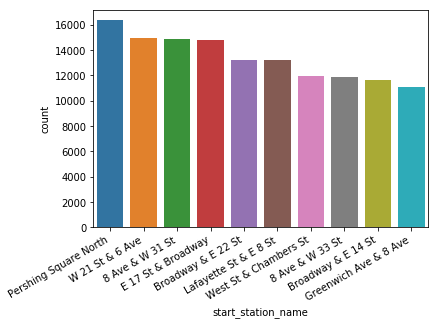

In [0]:
sns_plot5 = sns.countplot(x="start_station_name", data=df_trip1, order=pd.value_counts(df_trip1['start_station_name']).iloc[:10].index)
sns_plot5.set_xticklabels(sns_plot5.get_xticklabels(),rotation=30, ha="right")